# DATA: 

### ASTARR:

Active Peak calls from Junke: 

#### Select input peaks from the K562 ATAC-seq data that have q-value > 15

In [ ]:
%%bash
awk '$9 >15' /data/reddylab/Alex/encode4_duke/processing/atac_seq/210401_KS91_K562ASTARR_NovaSeq.hg38-pe-blacklist-removal/KS91_K562_hg38_ASTARRseq_Input_allReps.masked.dedup.sorted_peaks.narrowPeak \
| cut -f1,2,3,7 \
> /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/inputs/ASTARR/KS91_K562_hg38_ASTARRseq_Input_allReps.masked.dedup.sorted_peaks.cut.narrowPeak

# ASTARR

Junke's enhancer call pipeline has files named: inactive_bins_with_raw_count.bed which consists of all bins without enhancer activity (detected by her pipeline). 30bp_bin_10_step_size files were used for the analysis and hence has many overlapping bins. These are merged to get inactive regions and the mean of logFC is used for the overlapping bins

In [ ]:
%%bash
module load bedtools2
bedtools merge -i /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/processed/bin_level/inactive_bins_with_raw_count.bed \
-c 5 -o mean \
> /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/processed/bin_level/inactive_bins_with_raw_count.merged.bed

In [ ]:
!wc -l /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/processed/bin_level/inactive_bins_with_raw_count.merged.bed

Intersect the merged_inactive_bins with ATAC-seq peaks to find inactive bins with open chromatin regions

In [ ]:
%%bash
module load bedtools2
bedtools intersect \
-a /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/processed/bin_level/inactive_bins_with_raw_count.merged.bed \
-b /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/inputs/ASTARR/KS91_K562_hg38_ASTARRseq_Input_allReps.masked.dedup.sorted_peaks.cut.narrowPeak \
-wa \
-wb \
| cut -f1,2,3,4 \
> /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/processed/bin_level/inactive_bins_with_log2FC.input_sorted.bed


Random set of 5000 active peaks

In [ ]:
%%bash


Find the GC content of the active and inactive regions and select inactive regions with GC content comparable to the active regions

In [ ]:
%%bash
module load bedtools2
bedtools nuc -fi /data/reddylab/Reference_Data/Genomes/hg38/hg38.fa \
-bed /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/processed/bin_level/inactive_bins_with_log2FC.input_sorted.bed \
> /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/processed/bin_level/inactive_bins_with_log2FC.input_sorted.GC_content.txt
bedtools nuc -fi /data/reddylab/Reference_Data/Genomes/hg38/hg38.fa \
-bed /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_ASTARR.30bp_bin.merged_sig_up_in_each_orientation.random5000.bed \
> /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_ASTARR.30bp_bin.merged_sig_up_in_each_orientation.random5000.GC_content.txt

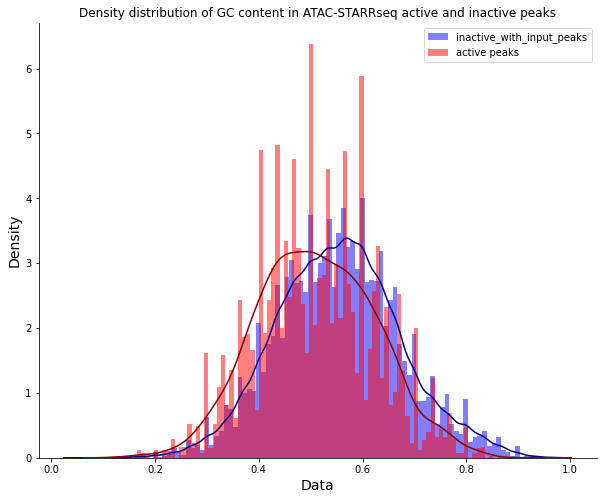

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

inactive_with_input_peaks = pd.read_csv('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/processed/bin_level/inactive_bins_with_log2FC.input_sorted.GC_content.txt', sep='\t')
active_peaks = pd.read_csv('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_ASTARR.30bp_bin.merged_sig_up_in_each_orientation.random5000.GC_content.txt', sep='\t')

plt.figure(figsize=(10,8))
density_inactive, bins_inactive, patches_inactive = plt.hist(inactive_with_input_peaks['6_pct_gc'], density=True, bins=100, alpha=0.5, color='blue', label="inactive_with_input_peaks")
density_active, bins_active, patches_active = plt.hist(active_peaks['11_pct_gc'], density=True, bins=100, alpha=0.5, color='red', label="active peaks")
sns.kdeplot(inactive_with_input_peaks['6_pct_gc'], color='darkblue')
sns.kdeplot(active_peaks['11_pct_gc'], color='darkred')
plt.xlabel("Data", size=14)
plt.ylabel("Density", size=14)
plt.legend(loc='upper right')
plt.title('Density distribution of GC content in ATAC-STARRseq active and inactive peaks')
sns.despine()
# plt.savefig('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/GC_content_matching/ASTARR.inactive_with_input_vs_active.GC_content.png')
plt.show()

In [ ]:
import random 
import numpy as np
import pandas as pd

random.seed(42)
df=None

count_active, bin_edge_active = np.histogram(active_peaks['11_pct_gc'], bins = 100)
sample_size = ((count_active.astype(int)/sum(count_active))*5020).astype(int)

for i in range(0,100):
    bin_start = bin_edge_active[i]
    bin_stop = bin_edge_active[i+1]
    inactive_with_input_peaks_v1 = inactive_with_input_peaks[(inactive_with_input_peaks['6_pct_gc']>=bin_start)&(inactive_with_input_peaks['6_pct_gc']<bin_stop)].reset_index()
    inactive_with_input_peaks_v1.drop(columns='index', inplace=True)
    
    count_active = count_active.astype(int)
    m = list(range(0, sample_size[i]))
    
    if not inactive_with_input_peaks_v1.empty:
        inactive_with_input_peaks_random = inactive_with_input_peaks_v1.loc[m]
        
        if df is None:
            df = inactive_with_input_peaks_random
        else:
            df = pd.concat([df,inactive_with_input_peaks_random])  

df = df.dropna().astype({'2_usercol':'int', '3_usercol':'int'})
df[['#1_usercol','2_usercol','3_usercol']].to_csv('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/processed/bin_level/inactive_with_input_peaks.GC_content_active_peaks.random5000.bed', sep='\t', index=False, header=None)

plt.figure(figsize=(10,8))
plt.hist(df['6_pct_gc'], density=True, bins=100, alpha=0.5, color='blue', label="inactive_with_input_peaks")
plt.hist(active_peaks['11_pct_gc'], density=True, bins=100, alpha=0.5, color='red', label="active_peaks")
sns.kdeplot(df['6_pct_gc'], color='darkblue')
sns.kdeplot(active_peaks['11_pct_gc'], color='darkred')
plt.xlabel("Data", size=14)
plt.ylabel("Density", size=14)
plt.legend(loc='upper right')
sns.despine()
plt.title('Density distribution of GC content in ATAC-STARRseq active and inactive peaks - after GC_content matching')
# plt.savefig('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/GC_content_matching/ASTARR.inactive_with_input_vs_active.GC_content_density_matched.png')
plt.show()

# LentiMPRA

Intersect LentiMPRA with ATAC-seq peaks

In [ ]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate revathy_py3
bedtools intersect \
-a /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/New_enhancer_call/lentiMPRA/lenti_mpra_tested_element_all.unique_peaks.bed \
-b /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/inputs/ASTARR/KS91_K562_hg38_ASTARRseq_Input_allReps.masked.dedup.sorted_peaks.cut.narrowPeak \
-wa \
-wb \
| cut -f1,2,3 \
> /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/New_enhancer_call/lentiMPRA/lenti_mpra_tested_element_all.unique_peaks.with_ATAC_peaks.bed


In [ ]:
!wc -l /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/New_enhancer_call/lentiMPRA/lenti_mpra_tested_element_all.unique_peaks.with_ATAC_peaks.bed

GC content matching

In [ ]:
%%bash
module load bedtools2
bedtools nuc -fi /data/reddylab/Reference_Data/Genomes/hg38/hg38.fa \
-bed /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/New_enhancer_call/lentiMPRA/lenti_mpra_tested_element_all.unique_peaks.with_ATAC_peaks.bed \
> /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/New_enhancer_call/lentiMPRA/lenti_mpra_tested_element_all.unique_peaks.with_ATAC_peaks.GC_content.txt
bedtools nuc -fi /data/reddylab/Reference_Data/Genomes/hg38/hg38.fa \
-bed /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/lenti_mpra_orientation_dep_call_all.merged.random5000.bed \
> /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/lenti_mpra_orientation_dep_call_all.merged.random5000.GC_content.txt


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

inactive_with_input_peaks = pd.read_csv('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/New_enhancer_call/lentiMPRA/lenti_mpra_tested_element_all.unique_peaks.with_ATAC_peaks.GC_content.txt', sep='\t')
active_peaks = pd.read_csv('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/lenti_mpra_orientation_dep_call_all.merged.random5000.GC_content.txt', sep='\t')

plt.figure(figsize=(10,8))
density_inactive, bins_inactive, patches_inactive = plt.hist(inactive_with_input_peaks['5_pct_gc'], density=True, bins=100, alpha=0.5,  color='blue', label="inactive_with_input_peaks")
density_active, bins_active, patches_active = plt.hist(active_peaks['5_pct_gc'], density=True, bins=100, alpha=0.5, color='red', label="active peaks")
sns.kdeplot(inactive_with_input_peaks['5_pct_gc'], color='darkblue')
sns.kdeplot(active_peaks['5_pct_gc'], color='darkred')
plt.xlabel("Data", size=14)
plt.ylabel("Density", size=14)
plt.legend(loc='upper right')
plt.title('Density distribution of GC content in LentiMPRA active and inactive peaks')
sns.despine()
plt.savefig('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/GC_content_matching/LentiMPRA.inactive_with_input_vs_active.GC_content.png')
plt.show()

In [ ]:
import random 
import numpy as np
import pandas as pd

random.seed(42)
df=None

count_active, bin_edge_active = np.histogram(active_peaks['5_pct_gc'], bins = 100)

sample_size = ((count_active.astype(int)/sum(count_active))*5020).astype(int)
for i in range(0,100):
    bin_start = bin_edge_active[i]
    bin_stop = bin_edge_active[i+1]
    inactive_with_input_peaks_v1 = inactive_with_input_peaks[(inactive_with_input_peaks['5_pct_gc']>=bin_start)&(inactive_with_input_peaks['5_pct_gc']<bin_stop)].reset_index()
    inactive_with_input_peaks_v1.drop(columns='index', inplace=True)
    
    count_active = count_active.astype(int)
    m = list(range(0, sample_size[i]))
    
    if not inactive_with_input_peaks_v1.empty:
        inactive_with_input_peaks_random = inactive_with_input_peaks_v1.loc[m]
        
        if df is None:
            df = inactive_with_input_peaks_random
        else:
            df = pd.concat([df,inactive_with_input_peaks_random])  

df = df.dropna().astype({'2_usercol':'int', '3_usercol':'int'})
df[['#1_usercol','2_usercol','3_usercol']].to_csv('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/New_enhancer_call/lentiMPRA/lenti_mpra_tested_element_all.unique_peaks.with_ATAC_peaks.GC_content.random5000.bed', sep='\t', index=False, header=None)

plt.figure(figsize=(10,8))
plt.hist(df['5_pct_gc'], density=True, bins=100, alpha=0.5, color='blue', label="inactive_with_input_peaks")
plt.hist(active_peaks['5_pct_gc'], density=True, bins=100, alpha=0.5, color='red', label="active_peaks")
sns.kdeplot(df['5_pct_gc'], color='darkblue')
sns.kdeplot(active_peaks['5_pct_gc'], color='darkred')
plt.xlabel("Data", size=14)
plt.ylabel("Density", size=14)
plt.legend(loc='upper right')
sns.despine()
plt.title('Density distribution of GC content in LentiMPRA active and inactive peaks - after GC_content matching')
plt.savefig('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/GC_content_matching/LentiMPRA.inactive_with_input_vs_active.GC_content_density_matched.png')
plt.show()



# wgSTARR-seq

Merge the inactive bins in wgSTARR with mean of logFC to get inactive merged regions 

In [ ]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
module load bedtools2
sbatch -p all \
       --cpus-per-task 1 \
       --mem 32G \
       -o /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/logs/wgSTARR_inactive_bins_merge.out \
      <<'EOF'
#!/bin/bash
bedtools merge -i /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/wgSTARR/processed/bin_level/inactive_bins_with_raw_count.bed \
-c 5 -o mean \
> /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/wgSTARR/processed/bin_level/inactive_bins_with_raw_count.merged.bed
EOF

Intersect the merged bins with ATAC-seq data

In [ ]:
%%bash
module load bedtools2
bedtools intersect \
-a /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/wgSTARR/processed/bin_level/inactive_bins_with_raw_count.merged.bed \
-b /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/inputs/ASTARR/KS91_K562_hg38_ASTARRseq_Input_allReps.masked.dedup.sorted_peaks.cut.narrowPeak \
-wa \
-wb \
| cut -f1,2,3,4 \
> /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/wgSTARR/processed/bin_level/inactive_bins_with_raw_count.merged.with_ATAC_peaks.bed


In [ ]:
!wc -l /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/wgSTARR/processed/bin_level/inactive_bins_with_raw_count.merged.with_ATAC_peaks.bed

GC content matching

In [ ]:
%%bash
module load bedtools2
bedtools nuc -fi /data/reddylab/Reference_Data/Genomes/hg38/hg38.fa \
-bed /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/wgSTARR/processed/bin_level/inactive_bins_with_raw_count.merged.with_ATAC_peaks.bed \
> /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/wgSTARR/processed/bin_level/inactive_bins_with_raw_count.merged.with_ATAC_peaks.GC_content.txt
bedtools nuc -fi /data/reddylab/Reference_Data/Genomes/hg38/hg38.fa \
-bed /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_wgSTARR.30bp_10bp_bin.sig_up.random5000.bed \
> /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_wgSTARR.30bp_10bp_bin.sig_up.random5000.GC_content.txt


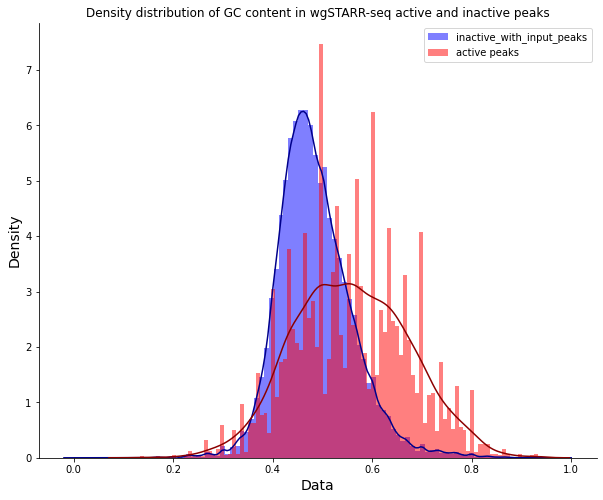

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

inactive_with_input_peaks = pd.read_csv('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/wgSTARR/processed/bin_level/inactive_bins_with_raw_count.merged.with_ATAC_peaks.GC_content.txt', sep='\t')
active_peaks = pd.read_csv('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_wgSTARR.30bp_10bp_bin.sig_up.random5000.GC_content.txt', sep='\t')


plt.figure(figsize=(10,8))
density_inactive, bins_inactive, patches_inactive = plt.hist(inactive_with_input_peaks['6_pct_gc'], density=True, bins=100, alpha=0.5, color='blue', label="inactive_with_input_peaks")
density_active, bins_active, patches_active = plt.hist(active_peaks['11_pct_gc'], density=True, bins=100, alpha=0.5, color='red', label="active peaks")
sns.kdeplot(inactive_with_input_peaks['6_pct_gc'], color='darkblue')
sns.kdeplot(active_peaks['11_pct_gc'], color='darkred')
plt.xlabel("Data", size=14)
plt.ylabel("Density", size=14)
plt.legend(loc='upper right')
plt.title('Density distribution of GC content in wgSTARR-seq active and inactive peaks')
sns.despine()
plt.savefig('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/GC_content_matching/wgSTARR.inactive_with_input_vs_active.GC_content.png')
plt.show()

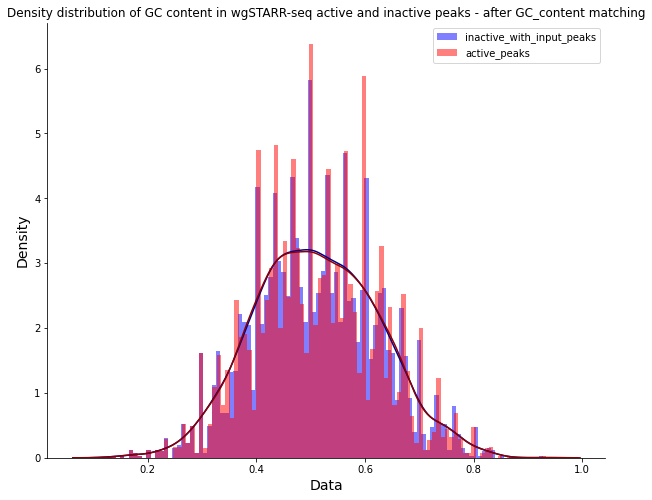

In [15]:
import random 
import numpy as np
import pandas as pd

random.seed(42)
df=None

count_active, bin_edge_active = np.histogram(active_peaks['11_pct_gc'], bins = 100)

sample_size = ((count_active.astype(int)/sum(count_active))*5020).astype(int)
for i in range(0,100):
    bin_start = bin_edge_active[i]
    bin_stop = bin_edge_active[i+1]
    inactive_with_input_peaks_v1 = inactive_with_input_peaks[(inactive_with_input_peaks['6_pct_gc']>=bin_start)&(inactive_with_input_peaks['6_pct_gc']<bin_stop)].reset_index()
    inactive_with_input_peaks_v1.drop(columns='index', inplace=True)
    
    count_active = count_active.astype(int)
    m = list(range(0, sample_size[i]))

    if not inactive_with_input_peaks_v1.empty:
        inactive_with_input_peaks_random = inactive_with_input_peaks_v1.loc[m]
        
        if df is None:
            df = inactive_with_input_peaks_random
        else:
            df = pd.concat([df,inactive_with_input_peaks_random])  

df = df.dropna().astype({'2_usercol':'int', '3_usercol':'int'})
# df[['#1_usercol','2_usercol','3_usercol']].to_csv('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/Junke_enhancer_calls_5Oct/wgSTARR/processed/bin_level/inactive_bins_with_raw_count.merged.with_ATAC_peaks.GC_content.random5000.bed', sep='\t', index=False, header=None)

plt.figure(figsize=(10,8))
plt.hist(df['6_pct_gc'], density=True, bins=100, alpha=0.5, color='blue', label="inactive_with_input_peaks")
plt.hist(active_peaks['11_pct_gc'], density=True, bins=100, alpha=0.5, color='red', label="active_peaks")
sns.kdeplot(df['6_pct_gc'], color='darkblue')
sns.kdeplot(active_peaks['11_pct_gc'], color='darkred')
plt.xlabel("Data", size=14)
plt.ylabel("Density", size=14)
plt.legend(loc='upper right')
sns.despine()
plt.title('Density distribution of GC content in wgSTARR-seq active and inactive peaks - after GC_content matching')
plt.savefig('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/GC_content_matching/wgSTARR.inactive_with_input_vs_active.GC_content_density_matched.png')
plt.show()
